<center><img src="https://i.imgur.com/1qejfmD.png" width="750px"></center>


# Introduction

In this tutorial, I will demonstrate how to build a simple MLP (Vanilla Neural Network) to recognize handwritten digits using PyTorch. These handwritten digit images are taken from the famous **MNIST database** which contains several thousands of (28 x 28) grayscale images representing the ten digits from 0 to 9. MNIST is the classic "Hello World!" of machine learning. It is a great place to get started with Deep Learning. The task is to take an image as input and predict which digit it is from 0 to 9 (classification).

# Preparing the ground

## Import necessary libraries

* Now, we import all the libraries we need.
* **matplotlib, tqdm, and plotly** for visualization.
* **numpy, pandas, keras, sklearn, and torch** for modelling.

In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.utils import to_categorical

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

Using TensorFlow backend.


## Set random seeds

* The next step is to set the random seed for NumPy and PyTorch.
* Setting the random seed helps us keep training determinstic and ensure reproducible results.

In [2]:
np.random.seed(27)
torch.manual_seed(27)

## Load the training and testing data

* Now we need to load the training and testing data.
* These dataframes contain the pixel data required to make predictions.

In [3]:
test_df = pd.read_csv('../input/digit-recognizer/test.csv')
train_df = pd.read_csv('../input/digit-recognizer/train.csv')

In [4]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modeling

* Next, we need to build a machine learning pipeline to recognize these handwritten digits.
* I will use a classic Vanilla Neural Network (VNN) also known as a Multi-layer Perceptron (MLP).

## Define PyTorch dataset

* The first step is to build a PyTorch dataset to generate data for our model.
* A PyTorch dataset has three fundamental functions: <code>init</code>, <code>len</code>, and <code>getitem</code>.
* The <code>init</code> function initializes all the components required for data loading (image data and labels data)
* The <code>len</code> function simply returns the length of the dataset. This indicates the number of retrievable samples.
* The <code>getitem</code> function returns a data point at a given index <code>idx</code>. The actual logic is written in this function.
* The <code>getitem</code> function does 2 things: gets the target and retrieves the 28 x 28 image at an <code>idx</code> (as a vector).

In [6]:
def to_tensor(data):
    return [torch.FloatTensor(point) for point in data]

class MNISTDataset(Dataset):
    def __init__(self, df, X_col, y_col):
        self.features = df[X_col].values/255
        self.targets = df[y_col].values.reshape((-1, 1))

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return to_tensor([self.features[idx], self.targets[idx]])

## Split train/valid (80/20)

* We now split the data into training and validation sets (train: 80%, valid: 20%).

In [7]:
y_col = "label"
test_df[y_col] = [-1]*len(test_df)

split = int(0.8*len(train_df))
valid_df = train_df[split:].reset_index(drop=True)
train_df = train_df[:split].reset_index(drop=True)

## Define the PyTorch dataloaders

* Now we create train and valid dataloaders to get data batches for the training and validation loops.

In [8]:
X_col = list(train_df.columns[1:])

train_set = MNISTDataset(train_df, X_col, y_col)
valid_set = MNISTDataset(valid_df, X_col, y_col)

valid_loader = DataLoader(valid_set, batch_size=1024, shuffle=True)
train_loader = DataLoader(train_set, batch_size=1024, shuffle=True)

## Define MLP model

* Next, we define the actual model which we are going to train.
* The MLP model includes an input layer (**784** neurons), and output layer (**10** neurons).
* There are two hidden layers of **20** and **15** neurons each (between the input and output layers).

In [9]:
class MLP(nn.Module):
    def __init__(self, i, u, v, o):
        super(MLP, self).__init__()
        self.relu_layer = nn.ReLU()
        self.dense_1 = nn.Linear(i, u)
        self.dense_2 = nn.Linear(u, v)
        self.dense_output = nn.Linear(v, o)
        
    def forward(self, x):
        x = self.relu_layer(self.dense_1(x))
        x = self.relu_layer(self.dense_2(x))
        logits = self.dense_output(x); return logits

### Define model and optimizer

In [10]:
device = torch.device('cuda')
network = MLP(i=784, u=20, v=15, o=10).to(device)
optimizer = Adam(params=network.parameters(), lr=0.01)

In [11]:
print(network)

MLP(
  (relu_layer): ReLU()
  (dense_1): Linear(in_features=784, out_features=20, bias=True)
  (dense_2): Linear(in_features=20, out_features=15, bias=True)
  (dense_output): Linear(in_features=15, out_features=10, bias=True)
)


## Define binary cross entropy and accuracy
* Next, we define our loss function (binary cross entropy) and evaluation metric (accuracy).

In [12]:
def cel(y_true, y_pred):
    y_true = y_true.long().squeeze()
    return nn.CrossEntropyLoss()(y_pred, y_true)

def acc(y_true, y_pred):
    y_true = y_true.long().squeeze()
    y_pred = torch.argmax(y_pred, axis=1)
    return (y_true == y_pred).float().sum()/len(y_true)

## Train the model on GPU

* Now, we train the model on the NVIDIA Tesla P100 GPU provided by Kaggle.
* First, we do a training loop, where we train the model with back-prop to adjust the parameters.
* Second, we do a validation loop, to check the model's performance on unseen data after each epoch.
* The training loop uses forward-prop and back-prop, while the validation loop uses only forward-prop.
* We use the <code>torch.no_grad()</code> flag for the validation loop as no gradients are needed for forward-prop.

In [13]:
start = time.time()
print("STARTING TRAINING ...\n")

train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(20):
    network = network.train()
    print("Epoch: {}".format(epoch + 1))
    batch_train_losses, batch_train_accuracies = [], []
    
    batch = 0
    for train_batch in train_loader:
        train_X, train_y = train_batch

        train_X = train_X.to(device)
        train_y = train_y.to(device)
        train_preds = network.forward(train_X)
        train_loss = cel(train_y, train_preds)
        train_accuracy = acc(train_y, train_preds)
        
        optimizer.zero_grad()
        train_loss.backward()
        
        optimizer.step()
        train_loss = np.round(train_loss.item(), 3)
        train_accuracy = np.round(train_accuracy.item(), 3)

        end = time.time()
        batch = batch + 1
        log = batch % 10 == 0
        time_delta = np.round(end - start, 3)
        
        batch_train_losses.append(train_loss)
        batch_train_accuracies.append(train_accuracy)
        logs = "Batch: {} || Train Loss: {} || Train Acc: {} || Time: {} s"
        if log: print(logs.format(batch, train_loss, train_accuracy, time_delta))
        
    train_losses.append(np.mean(batch_train_losses))
    train_accuracies.append(np.mean(batch_train_accuracies))
    
    total_valid_loss = 0
    total_valid_points = 0
    total_valid_accuracy = 0
    
    with torch.no_grad():
        for valid_batch in valid_loader:
            valid_X, valid_y = valid_batch
            
            valid_X = valid_X.to(device)
            valid_y = valid_y.to(device)
            valid_preds = network.forward(valid_X)
            valid_loss = cel(valid_y, valid_preds)
            valid_accuracy = acc(valid_y, valid_preds)
            
            total_valid_points += 1
            total_valid_loss += valid_loss.item()
            total_valid_accuracy += valid_accuracy.item()
            
    valid_loss = np.round(total_valid_loss/total_valid_points, 3)
    valid_accuracy = np.round(total_valid_accuracy/total_valid_points, 3)
    
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    
    end = time.time()
    time_delta = np.round(end - start, 3)
    logs = "Epoch: {} || Valid Loss: {} || Valid Acc: {} || Time: {} s"
    print("\n" + logs.format(epoch + 1, valid_loss, valid_accuracy, time_delta) + "\n")
    
print("ENDING TRAINING ...")

STARTING TRAINING ...

Epoch: 1
Batch: 10 || Train Loss: 1.279 || Train Acc: 0.612 || Time: 1.265 s
Batch: 20 || Train Loss: 0.664 || Train Acc: 0.785 || Time: 1.841 s
Batch: 30 || Train Loss: 0.439 || Train Acc: 0.854 || Time: 2.248 s

Epoch: 1 || Valid Loss: 0.4 || Valid Acc: 0.879 || Time: 2.678 s

Epoch: 2
Batch: 10 || Train Loss: 0.398 || Train Acc: 0.882 || Time: 3.086 s
Batch: 20 || Train Loss: 0.349 || Train Acc: 0.894 || Time: 3.495 s
Batch: 30 || Train Loss: 0.307 || Train Acc: 0.904 || Time: 3.9 s

Epoch: 2 || Valid Loss: 0.295 || Valid Acc: 0.915 || Time: 4.333 s

Epoch: 3
Batch: 10 || Train Loss: 0.257 || Train Acc: 0.93 || Time: 4.744 s
Batch: 20 || Train Loss: 0.239 || Train Acc: 0.932 || Time: 5.275 s
Batch: 30 || Train Loss: 0.25 || Train Acc: 0.928 || Time: 5.801 s

Epoch: 3 || Valid Loss: 0.232 || Valid Acc: 0.931 || Time: 6.388 s

Epoch: 4
Batch: 10 || Train Loss: 0.188 || Train Acc: 0.948 || Time: 6.811 s
Batch: 20 || Train Loss: 0.215 || Train Acc: 0.924 || Time: 

## Visualize metrics over time

* Now, we visualize how the metrics (loss and accuracy) change over time.

In [14]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, len(valid_losses)),
                         y=valid_losses, mode="lines+markers", name="valid",
                         marker=dict(color="indianred", line=dict(width=.5,
                                                                  color='rgb(0, 0, 0)'))))

fig.add_trace(go.Scatter(x=np.arange(1, len(train_losses)),
                         y=train_losses, mode="lines+markers", name="train",
                         marker=dict(color="darkorange", line=dict(width=.5,
                                                                   color='rgb(0, 0, 0)'))))

fig.update_layout(xaxis_title="Epochs", yaxis_title="Cross Entropy",
                  title_text="Cross Entropy vs. Epochs", template="plotly_white", paper_bgcolor="#f0f0f0")

fig.show()

The loss seems to converge over time towards a good value (0.18).

In [15]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, len(valid_accuracies)),
                         y=valid_accuracies, mode="lines+markers", name="valid",
                         marker=dict(color="indianred", line=dict(width=.5,
                                                                  color='rgb(0, 0, 0)'))))

fig.add_trace(go.Scatter(x=np.arange(1, len(train_accuracies)),
                         y=train_accuracies, mode="lines+markers", name="train",
                         marker=dict(color="darkorange", line=dict(width=.5,
                                                                   color='rgb(0, 0, 0)'))))

fig.update_layout(xaxis_title="Epochs", yaxis_title="Accuracy",
                  title_text="Accuracy vs. Epochs", template="plotly_white", paper_bgcolor="#f0f0f0")

fig.show()

The accuracy seems to converge over time towards a good value (0.95).

## Run inference on the test data

* The final step is to infer the model on the test data.
* We create a test dataloader and iterate through it using a loop with <code>torch.no_grad()</code> enabled.
* The generated predictions are passed through the <code>softmax</code> function to convert logits to probabilities.

In [16]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)[:, None]

In [17]:
test_set = MNISTDataset(test_df, X_col, y_col)
test_loader = tqdm(DataLoader(test_set, batch_size=1024, shuffle=False))

test_preds = []
with torch.no_grad():
    for test_X, _ in test_loader:
        test_X = test_X.to(device)
        test_pred = network.forward(test_X)
        test_preds.append(softmax(test_pred.detach().cpu().numpy()))

## Prepare submission

* Next, we find the indices of maximum probability using <code>np.argmax</code>.
* These indices represent our final prediction from 0 to 9 (for the digit).

In [18]:
submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
submission["Label"] = np.argmax(np.concatenate(test_preds, axis=0), axis=1)

## Visualize predictions

* Now, we visualize some sample test predictions.
* The red label above each image is the prediction made by the model.

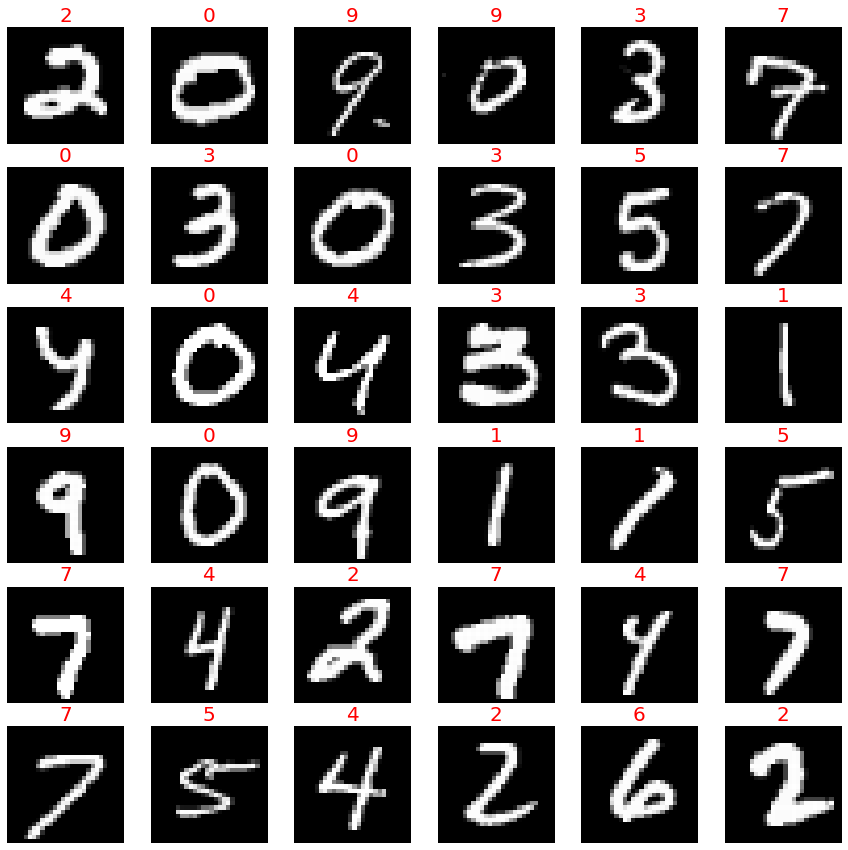

In [19]:
test_batch = next(iter(test_loader))[0]
test_X = test_batch.reshape(-1, 28, 28)[:36]
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))

for i, image in enumerate(test_X):
    ax[i//6][i%6].axis('off'); ax[i//6][i%6].imshow(image, cmap='gray')
    ax[i//6][i%6].set_title(np.argmax(test_preds[0][i], axis=0), fontsize=20, color="red")

The model is able to classify almost all images. But, it is getting confused in certain cases.

In [20]:
submission.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


## Submit submission file

* Finally, we convert our submission dataframe to a .csv file for submission.

In [21]:
submission.to_csv("submission.csv", index=False)

# Takeaways

* The MLP model is able to predict handwritten digits with an accuracy of 94.7 %.
* The performance can be improved by using Convolutional Neural Networks (CNNs).
* CNNs are specialized architectures made for computer vision (built to understand spatial features).
* Using a flattened 784D vector makes it difficult to capture spatial relationships. But, an MLP is a great start.